# PyStan

I now illustrate the use of the latest Hamiltonian Monte Carlo (HMC) algorithm, the No-U Turn Sampler (NUTS) of Hoffman and Gelman (2011), as implemented in the package Stan, see mc-stan.org for detailed information. 

Stan is written in C++ and can be run from the command line, R or Python. Here we illustrate running it on the  data using the Python-interface PyStan.

PyStan is a python interface to STAN, a C++ library for building Bayesian models and sampling them with Markov Chain Monte Carlo (MCMC). 

### Install PyStan with

pip install pystan

# Imports and Interactive magics

In [1]:
%reset -f

%matplotlib inline
%qtconsole --colors=linux

#!pip install pyparsing pydot
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import optimize
import patsy as pt
import statsmodels.api as sm

import pymc3 as pm
import theano as thno
import theano.tensor as T 
import pystan

# configure some basic options
sns.set(style="darkgrid", palette="muted")
pd.set_option('display.notebook_repr_html', True)
plt.rcParams['figure.figsize'] = 12, 8
np.random.seed(0)

# Versions

In [2]:
print('Python: {}'.format(sys.version))
print('pystan: {}'.format(pystan.__version__))
print('theano: {}'.format(thno.__version__))
print('PyMC3: {}'.format(pm.__version__))
print('Recursion limit {}'.format(sys.getrecursionlimit()))

import psutil
import multiprocessing


print ('CPU: {}'.format(multiprocessing.cpu_count()))
print ('CPU: {}'.format(psutil.cpu_count()))

! which python
! python --version
#!pip install watermark
%load_ext watermark
%watermark -d -v -m -p pandas,scipy,matplotlib,tensorflow

Python: 2.7.6 (default, Oct 26 2016, 20:30:19) 
[GCC 4.8.4]
pystan: 2.14.0.0
theano: 0.8.2
PyMC3: 3.0
Recursion limit 10000
CPU: 4
CPU: 4
/usr/bin/python
Python 2.7.6
2017-03-04 

CPython 2.7.6
IPython 5.3.0

pandas 0.19.2
scipy 0.13.3
matplotlib 2.0.0
tensorflow 0.11.0

compiler   : GCC 4.8.4
system     : Linux
release    : 4.9.12-moby
machine    : x86_64
processor  : x86_64
CPU cores  : 4
interpreter: 64bit


# Locally defined methods

In [3]:
import pickle
from hashlib import md5

# Cache stan models so that they are not recompiled
def cacheStan(model_code, model_name=None, **kwargs):
    """Use just as you would `stan`"""
    code_hash = md5(model_code.encode('ascii')).hexdigest()
    if model_name is None:
        cache_fn = 'cached-model-{}.pkl'.format(code_hash)
    else:
        cache_fn = 'cached-{}-{}.pkl'.format(model_name, code_hash)
    try:
        sm = pickle.load(open(cache_fn, 'rb'))
    except:
        sm = pystan.StanModel(model_code=model_code)
        with open(cache_fn, 'wb') as f:
            pickle.dump(sm, f)
    else:
        print("Using cached StanModel")
    return sm.sampling(**kwargs) 

def getStanCode(file_name):
    f = open(file_name)
    code = f.read()
    f.close()
    return code

# Prepare and Preprocess Data

As input, PyStan will need to be supplied with:

* The response variable (y)
* The predictor variable (x)
* The total number of observed items (n)

In [4]:
# Make a data frame
df_kar = pd.DataFrame(np.array([
           75, 82, 77, 86, 98, 91, 85, 84, 82, 79,
           88, 79, 84, 87, 69, 93, 84, 82, 89, 78,
           90, 74, 75, 84, 89, 81, 74, 79, 82, 84]),
           columns=['x'])
df_kar.head()

,x
0,75
1,82
2,77
3,86
4,98


## Plot the distribution
Use distplot() to fit a parametric distribution to our dataset and visually evaluate how closely it corresponds to the observed data.

/usr/local/lib/python2.7/dist-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


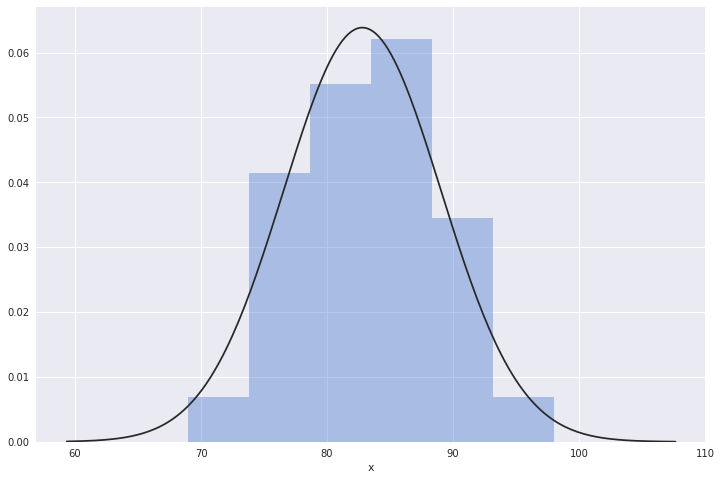

In [5]:
# df_kar.plot()
from scipy import stats, integrate
# sns.distplot(df_kar['x']);
sns.distplot(df_kar['x'], kde=False, fit=stats.norm);

# Design an ML Model

## Analytically (not the real model, fix teh latex)


$$
y_i\sim{}N(\mu_i, \sigma)\\
\mu_i = \beta_0+\beta_1 x_i\\
\beta_0\sim{}N(0,1000)\\
\beta_1\sim{}N(0,1000)\\
\sigma\sim{}Cauchy(0,5)\\
$$

## Using PyStan

### Structure of a stan model

Note the following important characteristics of stan code:

* A stan model file comprises a number of blocks (not all of which are compulsory).
* The stan language is an intermediary between (PyStan and c++), stan requires all types (integers, vectors, matrices etc) to be declared prior to use and it uses c++ commenting (// and /* */)
*  Code order is important, objects must be declared before they are used. When a type is declared in one block, it is available in subsequent blocks.

In [6]:
ML_MODEL_NORMAL= """
// declare the input data / parameters
  data {
    int<lower=0> N;       # number of data
    real<lower=0> x[N];   # vector of input 
  }
  
// optional - for transforming/scaling input data  
  transformed data {  
  }
 
  parameters {
    real<lower=0> mu;     # mean
    real<lower=0> stdev;  # standard deviation
  }
// specifying priors and likelihood as well as the predictor  
  model {
    x ~ normal(mu, stdev);  # normal distribution model, defined by variance rather than precision
  }
// optional - derivatives (posteriors) of the samples  
  generated quantities {
    real<lower=0> borderline;             # 90% percentile
    real<lower=0, upper=1> qualifying;    # probability of qualifying karaoke contest
    borderline = mu + 1.282 * stdev;
    qualifying = 1 - normal_cdf(borderline, 87, 5);
    //rss = dot_self(x-mu);
    //totalss = dot_self(x-mean(x));
    //R2 = 1 - rss/totalss;
    
    //real[N] log_lik;
    //for (i in 1:N){
      //log_lik[i] <- normal_log(x[i], mu[i], stdev);
    //}
  }       
"""

# Define and Run the model

## Define the MCMC chain parameters

For the parameters of the No-U-Turn sampling chains, include the following:

* The nodes (estimated parameters) to monitor (return samples for)
* The number of MCMC chains (4)
* The number of warmup steps (1000)
* The thinning factor (1)
* The number of MCMC iterations - determined by the number of samples to save, the rate of thinning and the number of chains


In [7]:
nChains = 4
burnInSteps = 1000
thinSteps = 1
numSavedSteps = 15000 #across all chains
nIter = (int)(np.ceil(burnInSteps+(numSavedSteps * thinSteps)/nChains))
nIter

4750

## Define an input dictionary for Stan

* Create a dictionary containing all data to be passed to STAN

In [8]:
stan_datadict = {}
stan_datadict['N'] = df_kar.shape[0]
stan_datadict['x'] = df_kar['x'].values
stan_datadict.items()

[('x',
  array([75, 82, 77, 86, 98, 91, 85, 84, 82, 79, 88, 79, 84, 87, 69, 93, 84,
         82, 89, 78, 90, 74, 75, 84, 89, 81, 74, 79, 82, 84])),
 ('N', 30)]

## Compile model and sample

In [9]:
import pystan
import matplotlib.pyplot as plt
import numpy as np
from pystan import StanModel

fit = pystan.stan(model_code=ML_MODEL_NORMAL, 
                  data=stan_datadict, 
                  iter=nIter, 
                  chains=nChains, 
                  n_jobs=1,
                  warmup=burnInSteps,
                  thin=1)
# fit = cacheStan(model_code=ML_MODEL_NORMAL, data=OneVar_dat)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_802410be4c83000af862d9ee33c4a519 NOW.


## Visualize the fit

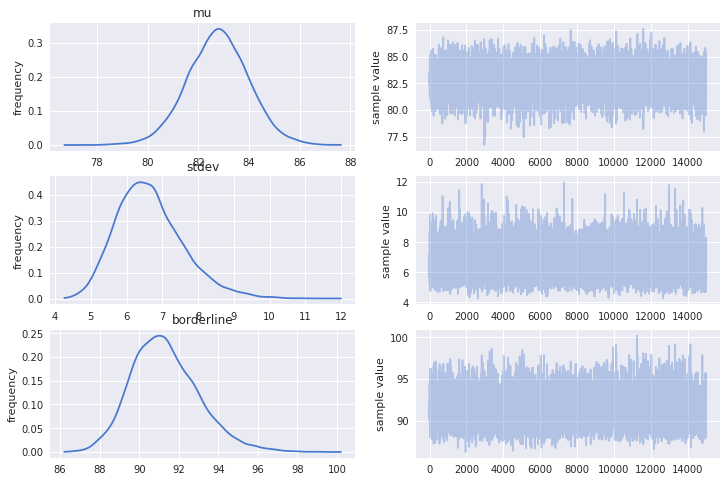

In [10]:
fit.plot(pars=['mu', 'stdev', 'borderline'])
plt.show()
# fit.plot()

## View summary stats

In [11]:
print(fit)

Inference for Stan model: anon_model_802410be4c83000af862d9ee33c4a519.
4 chains, each with iter=4750; warmup=1000; thin=1; 
post-warmup draws per chain=3750, total post-warmup draws=15000.

             mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu          82.79    0.01   1.21  80.39  81.99  82.79  83.59  85.17  11922    1.0
stdev        6.65  9.0e-3   0.94    5.1   5.99   6.56    7.2   8.83  10964    1.0
borderline  91.32    0.02   1.71  88.36  90.12  91.17  92.37  95.09  11798    1.0
qualifying   0.21  7.9e-4   0.09   0.05   0.14    0.2   0.27   0.39  12577    1.0
lp__       -64.75    0.01   1.06 -67.67 -65.15 -64.42  -64.0 -63.73 6334.0    1.0

Samples were drawn using NUTS at Sat Mar  4 13:45:07 2017.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


# Print statistics

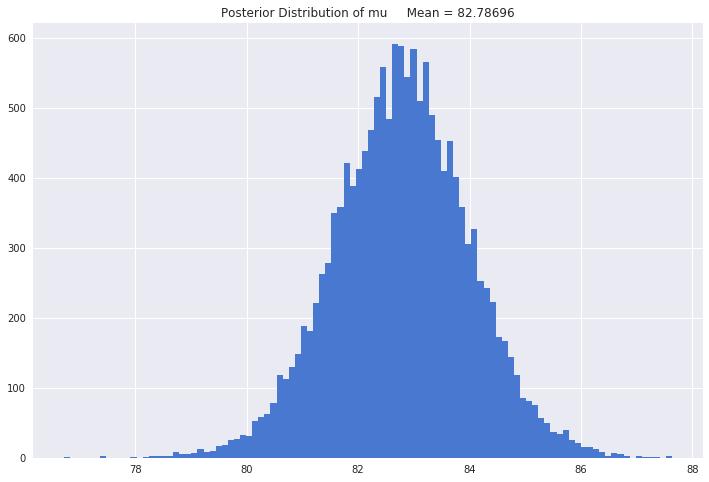

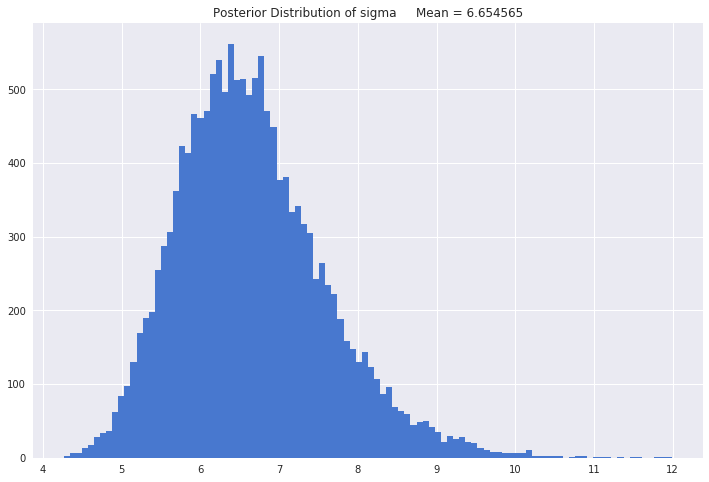

In [12]:
LResults = fit.extract(permuted=True)
Lmu = LResults['mu']
meanMu = np.mean(Lmu)
plt.figure()
plt.title("Posterior Distribution of mu     Mean = {0:.7}".format(meanMu))
plt.hist(Lmu, bins = 100)
plt.show()
    

Lsigma = LResults['stdev']
meanSigma = np.mean(Lsigma)
plt.figure()   
plt.title("Posterior Distribution of sigma     Mean = {0:.7}".format(meanSigma))
plt.hist(Lsigma, bins = 100)
plt.show()

# Classical Linear Regression

$$ y_i = \beta_0 + \Sigma \beta_x * x_i + \epsilon \\
\epsilon \sim  N(\mu, \sigma^2) $$

# Bayesian Linear Regression

$$ y_i \sim N(\mu, \sigma^2) \\
\mu = \beta_0 + \Sigma \beta_x * x_i \\
\beta_x \sim priors $$

# Bayesian Logistic Regression
## logit
$$ \begin{array}{rcl}
			  y &\sim& \operatorname{Bern}(\pi)\\
			  log\left(\frac{\pi}{1-\pi}\right)&=&\beta_0+\beta_1x_1\\
			  \beta_0, \beta_1&\sim&\mathcal{N}(0, 10000)\\
			  \end{array} $$
## ?              
$$
p(Y_i \mid X_i,\beta) \sim \text{Binomial}(n_i,p_i) \\ \text{where } p_i = \text{logit}^{-1}(\beta^TX)
$$
see http://rstudio-pubs-static.s3.amazonaws.com/15619_15a956c6bda84c3f97ef32793895689a.html#/16 for why classical LR may be bad. 

## probit

$$ \begin{array}{rcl}
			  y &\sim& \operatorname{Bern}(\pi)\\
			  \phi^{-1}\left(\pi\right)&=&\beta_0+\beta_1x_1\\
			  \beta_0, \beta_1&\sim&\mathcal{N}(0, 10000)\\
			  \end{array}$$ 

### LD50
We might also be interested in the LD50 - the value of x where the probability switches from favoring 1 to favoring 0. LD50 is calculated as:
$$
LD50 = - \frac{intercept}{slope}
$$

In [106]:
# Stan models

ML_MODEL_LOGREG= """
data {
     int<lower=1> K;
     int<lower=0> N;
     int<lower=0,upper=1> y[N];
     matrix[N,K] x;
   }
   parameters {
     vector[K] beta;
   }
   model {
     beta ~ normal(0,1); // prior
     y ~ bernoulli_logit(x * beta); //likelihood
   } 
"""   

# logistic = invlogit 
ML_MODEL_LOGREG= """ 
data {
	int<lower=0> N;
	real x[N];
	int<lower=0,upper=1> y[N];
}
parameters {
	real alpha;
	real beta;
}
model {
	for (n in 1:N)
		y[n] ~ bernoulli(inv_logit(alpha + beta * x[n]));
}
"""

logitReg = """
data {
  int<lower=0> N; 
  real x1[N]; 
  real x2[N]; 
  int<lower=0,upper=1> y[N];
}

parameters {
  real alpha; 
  real beta1; 
  real beta2;
}

model {
  alpha ~ normal(0,10.); 
  beta1 ~ normal(0,10.); 
  beta2 ~ normal(0,10.);
  for (n in 1:N)
    y[n] ~ bernoulli(inv_logit(alpha + beta1 * x1[n]+beta2 * x2[n]));
}'
"""

logitReg = """
data {
        int<lower=0> N;
        int<lower=0> M;
        matrix[N, M] X;
        int<lower=0, upper=1> y[N];
    }
    parameters {
        real beta0;
        vector[M] beta;
    }
    model {
        for (i in 1:N)            
            y[i] ~ bernoulli(inv_logit (beta0 + dot_product(X[i] , beta)));
    }
"""    
    

Refs:

https://matthewdharris.com/2016/10/18/estimating-a-beta-distribution-with-stan-hmc/

https://github.com/jonsedar/pymc3_vs_pystan/blob/master/01_BasicInstallTests.ipynb

http://brabrajp.blogspot.co.il/2016/05/pystan.html

http://www.flutterbys.com.au/stats/tut/tut7.2b.html

http://tjo.hatenablog.com/entry/2014/03/25/194605
